# Elements of success in iOS's App Store
As of September 2018, there were approximately 2 million iOS apps available on the App Store. By looking at a sample of those, we'll ask the questions:

> Are there shared elements that contribute to **free** mobile application's *success*?

> Are there shared elements that contribute to **free** mobile application's *failure*?

### OBJECTIVE
By the end of this analysis we expect a graphical representation of the correlation between specific elements and the success/failure of the app. The **elements to be evaluated** are:
- App's name length & key words
- App's genre in comparision to other genres
- App's size in bytes

And the **success/failure** will be defined as a score considering:
- Absolute Rating Count
- Average Rating itself
- These measures considering both overall and grouped in genres

### FLOW STRUCTURE
Throughout this document the colors as well as title numbers (1, 2...) will indicate in which part of the flow we are. By the end you can find the summary of the findings.
1. <font color=red>**Data Cleaning**</font>: Making sure the data is properly displayed before analysis
2. <font color=purple>**Success Score**</font>: Generating the score and ranking the apps accordingly
3. <font color=orange>**Splitting Sample**</font>: Defining the borderline between Success & Failure
4. <font color=blue>**Element's Evaluation**</font>: Correlation analysis between each element and the Success score
5. <font color=green>**Conclusion**</font>: Summary of the findings

### LIBRARIES
- Pandas
- Numpy
- Matplotlib
- Scipy
- Itertools
- Regex

### RESOURCES

In [72]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import itertools
import scipy.stats as sp
%matplotlib inline

In [2]:
apple_store = pd.read_csv("AppleStore.csv")
print("The dataset contains", apple_store.shape[0],
      "rows and", apple_store.shape[1],
      "columns. Here are the first five rows:")
apple_store.head()

The dataset contains 7197 rows and 16 columns. Here are the first five rows:


id               track_name  size_bytes currency  price  \
0  284882215                 Facebook   389879808      USD    0.0   
1  389801252                Instagram   113954816      USD    0.0   
2  529479190           Clash of Clans   116476928      USD    0.0   
3  420009108               Temple Run    65921024      USD    0.0   
4  284035177  Pandora - Music & Radio   130242560      USD    0.0   

   rating_count_tot  rating_count_ver  user_rating  user_rating_ver      ver  \
0           2974676               212          3.5              3.5     95.0   
1           2161558              1289          4.5              4.0    10.23   
2           2130805               579          4.5              4.5  9.24.12   
3           1724546              3842          4.5              4.0    1.6.2   
4           1126879              3594          4.0              4.5    8.4.1   

  cont_rating        prime_genre  sup_devices.num  ipadSc_urls.num  lang.num  \
0          4+  Social Networking               37                1        29   
1         12+      Photo & Video               37                0        29   
2          9+              Games               38                5        18   
3          9+              Games               40                5         1   
4         12+              Music               37                4         1   

   vpp_lic  
0        1  
1        1  
2        1  
3        1  
4        1

By a first look, we can already define which are the columns we want to keep and which are the ones we'll drop. Here's a table to explain the whole dataset content and what will actually be useful to us.

| Column | Description | Keep | Why? | Rename to |
| :--- | :--- | :--- | :--- | :--- |
| "id" | App ID | **Yes** | It might help us when trying to identify duplicates | "id" |
| "track_name" | App Name | **Yes** | Identifying the mobile apps | "app_name" |
| "size_bytes" | Size (in Bytes) | **Yes** | If the data shows itself reliable, it can be a point of analysis | "size_bytes" |
| "currency" | Currency Type | No | The focus is on free apps, so this information is irrelevant | - |
| "price" | Price amount | **Yes** | To identify the free apps | "price" |
| "ratingcounttot" | User Rating counts (for all version) | **Yes** | Is the only indicator we have to have an idea of number of active users | "rating_count" |
| "ratingcountver" | User Rating counts (for current version) | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "user_rating" | Average User Rating value (for all version) | **Yes** | As a quality indicator, it's going to help to measure success | "rating" |
| "userratingver" | Average User Rating value (for current version) | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "ver" | Latest version code | No | Our analysis is looking at the big picture, so version information is not meaningful | - |
| "cont_rating" | Content Rating | No | It's not under our analysis objective to understand about content rating | - |
| "prime_genre" | Primary Genre | **Yes** | It will serve to group the apps in different categories, and evaluate each group with it's alikes | "genre" |
| "sup_devices.num" | Number of supporting devices | No | Although it might seem important to our analysis, it's already trivial that an app with a large range of devices has a greater chance to be successuful | - |
| "ipadSc_urls.num" | Number of screenshots showed for display | No | It's a relevant information, yet not the main focus of the analysis | - |
| "lang.num" | Number of supported languages | No | Although it might seem important to our analysis, it's already trivial that an app with a large range of devices has a greater chance to be successuful | - |
| "vpp_lic" | Vpp Device Based Licensing Enabled | No | The licensing is not relevant to our analysis's objective | - |


## 1. <font color=red>Data Cleaning</font>

The cleaning process is going to follow the order:
- Dropping/Reordering columns
- Renaming columns
- Implementing proper data-types to the columns
- Inspecting NaN values and any other wrong inputs
- Dropping paid apps
- Dealing with duplicates

In [3]:
apple_crop = apple_store.copy()[["id", "track_name", "prime_genre", "size_bytes", "price", "rating_count_tot", "user_rating"]]
apple_crop.columns = ["id", "app_name", "genre", "size_bytes", "price", "rating_count", "rating"]
apple_crop.head()

id                 app_name              genre  size_bytes  price  \
0  284882215                 Facebook  Social Networking   389879808    0.0   
1  389801252                Instagram      Photo & Video   113954816    0.0   
2  529479190           Clash of Clans              Games   116476928    0.0   
3  420009108               Temple Run              Games    65921024    0.0   
4  284035177  Pandora - Music & Radio              Music   130242560    0.0   

   rating_count  rating  
0       2974676     3.5  
1       2161558     4.5  
2       2130805     4.5  
3       1724546     4.5  
4       1126879     4.0

In [4]:
for c in apple_crop.columns:
    print(c, ':', apple_crop[c].dtype)

id : int64
app_name : object
genre : object
size_bytes : int64
price : float64
rating_count : int64
rating : float64


In [5]:
print("Are there any NaN values looking column by column?", '\n')
for c in apple_crop.columns:
    print(apple_crop[c].isna().value_counts(), '\n')

Are there any NaN values looking column by column? 

False    7197
Name: id, dtype: int64 

False    7197
Name: app_name, dtype: int64 

False    7197
Name: genre, dtype: int64 

False    7197
Name: size_bytes, dtype: int64 

False    7197
Name: price, dtype: int64 

False    7197
Name: rating_count, dtype: int64 

False    7197
Name: rating, dtype: int64 



In [6]:
apple_free = apple_crop.copy()[apple_crop['price'] == 0]
print("The new dataset with only free apps contains",
      apple_free.shape[0], "rows and", apple_free.shape[1],
      "columns. Here are the first five rows:")
apple_free.head()

The new dataset with only free apps contains 4056 rows and 7 columns. Here are the first five rows:


id                 app_name              genre  size_bytes  price  \
0  284882215                 Facebook  Social Networking   389879808    0.0   
1  389801252                Instagram      Photo & Video   113954816    0.0   
2  529479190           Clash of Clans              Games   116476928    0.0   
3  420009108               Temple Run              Games    65921024    0.0   
4  284035177  Pandora - Music & Radio              Music   130242560    0.0   

   rating_count  rating  
0       2974676     3.5  
1       2161558     4.5  
2       2130805     4.5  
3       1724546     4.5  
4       1126879     4.0

In [7]:
print("Out of the remaining dataset, how many rows are duplicated taking into consideration the \"app_name\"?")
apple_free.duplicated("app_name", keep=False).value_counts()

Out of the remaining dataset, how many rows are duplicated taking into consideration the "app_name"?


False    4052
True        4
dtype: int64

In [8]:
print("These are the duplicated rows:")
apple_free[apple_free.duplicated("app_name", keep=False)]

These are the duplicated rows:


id             app_name  genre  size_bytes  price  rating_count  \
2948  1173990889  Mannequin Challenge  Games   109705216    0.0           668   
4442   952877179    VR Roller Coaster  Games   169523200    0.0           107   
4463  1178454060  Mannequin Challenge  Games    59572224    0.0           105   
4831  1089824278    VR Roller Coaster  Games   240964608    0.0            67   

      rating  
2948     3.0  
4442     3.5  
4463     4.0  
4831     3.5

After looking at the duplicated rows, it's noticeable that although the names are exactly the same, the **"size_bytes"**, **"id"**, **"rating_count"**, and **"rating"** actually present differences, taking us to assume these are different apps, just with the coincidence of having the same name - which is also not very unique or individually branded in any way. For this reason, we <font color=red>**will not drop**</font> these rows.

To finalize the cleaning process we will drop a few more columns that are no longer needed for the upcoming analysis. Those being: "id" and "price".

In [9]:
apple_final = apple_free.copy()[["app_name", "genre", "size_bytes", "rating_count", "rating"]]
apple_final.head()

app_name              genre  size_bytes  rating_count  \
0                 Facebook  Social Networking   389879808       2974676   
1                Instagram      Photo & Video   113954816       2161558   
2           Clash of Clans              Games   116476928       2130805   
3               Temple Run              Games    65921024       1724546   
4  Pandora - Music & Radio              Music   130242560       1126879   

   rating  
0     3.5  
1     4.5  
2     4.5  
3     4.5  
4     4.0

## 2. <font color=purple>Success Score</font>
To generate the score and rank the apps accordingly we will follow the steps:
- Defining variables and it's weights
- Defining Success Rate Formula
- Implementing first Overall then Genre scores
- Visualize the results and apply changes if needed

The score is going to take into consideration two criteria:
- The **app overall** numbers with respect to all other apps
- The app numbers with respect to apps **within the same "genre**"

For both perspectives the indicators we will be looking at are "rating_count" and "rating". Both of them provide first an absolute number which indirectly translates the number of users that utilize these apps, and second those users evaluation over the product.

Wouldn't it be better to measure how many users in total, insted of rating_count?
> Yes, definitely. However we don't have access to this data, so our assumption is going to rely on idea that the more ratings counted, means more active users, more installs and ultimately more success.

<div class="alert alert-block alert-info">
<b>App Overall:</b> We want two equivalent scores, one for "rating_count" and another for "rating" in which we can apply different weights and sum them to result in a number ranging between 0 and 1.
</div>

<div class="alert alert-block alert-info">
<b>App within Genre:</b> Similarly we want the same scores, however comparing only within it's "genre".
</div>

<div class="alert alert-block alert-warning">
<b>Final Success Score:</b> (Overall Score * Weight) + (Genre Score * Weight)
</div>

The nature of the numbers are radically different ("rating_count" can go up to millions and it's an absolute number, while "rating" range from 0 to 5 and it's the result of an average calculation). With this in mind, to generate the coefficients ranging between 0 and 1 that can be equivalent, we will use the ***Min-max feature scaling***:

[Reference](https://en.wikipedia.org/wiki/Normalization_(statistics))

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/0222c9472478eec2857b8bcbfa4148ece4a11b84" alt="Min-max feature scaling" title="Min-max feature scaling" />

*For future references:*
- **'rc'** refers to **"rating_count"**
- **'r'** refers to **"rating"**

In [10]:
weight_rc = 0.4
weight_r = 0.6

### OVERALL SCORE
---

In [11]:
def minmax_scaling_overall(x, column):
    # Column is either 'r' or 'rc'
    if column == 'rc':
        min_ = apple_final['rating_count'].min()
        max_ = apple_final['rating_count'].max()
        return (x - min_) / (max_ - min_)
    elif column == 'r':
        min_ = apple_final['rating'].min()
        max_ = apple_final['rating'].max()
        return (x - min_) / (max_ - min_)
    else:
        return "Wrong 'column' input"

In [12]:
apple_final['overall_rc'] = apple_final['rating_count'].apply(minmax_scaling_overall, column='rc')
apple_final['overall_r'] = apple_final['rating'].apply(minmax_scaling_overall, column='r')
apple_final.head()

app_name              genre  size_bytes  rating_count  \
0                 Facebook  Social Networking   389879808       2974676   
1                Instagram      Photo & Video   113954816       2161558   
2           Clash of Clans              Games   116476928       2130805   
3               Temple Run              Games    65921024       1724546   
4  Pandora - Music & Radio              Music   130242560       1126879   

   rating  overall_rc  overall_r  
0     3.5    1.000000        0.7  
1     4.5    0.726653        0.9  
2     4.5    0.716315        0.9  
3     4.5    0.579742        0.9  
4     4.0    0.378824        0.8

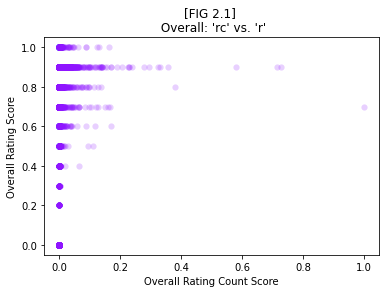

In [13]:
x = apple_final['overall_rc']
y = apple_final['overall_r']
plt.scatter(x, y, c='#8f15ff', alpha=0.2, linewidths=0.1)
plt.xlabel("Overall Rating Count Score")
plt.ylabel("Overall Rating Score")
plt.title("[FIG 2.1] \n Overall: 'rc' vs. 'r'")
plt.show()

In [14]:
apple_final['overall_score'] = (apple_final['overall_rc'] * weight_rc) + (apple_final['overall_r'] * weight_r)

In [15]:
apple_final['overall_score'].describe()

count    4056.000000
mean        0.407863
std         0.199216
min         0.000000
25%         0.360041
50%         0.480201
75%         0.540388
max         0.830661
Name: overall_score, dtype: float64

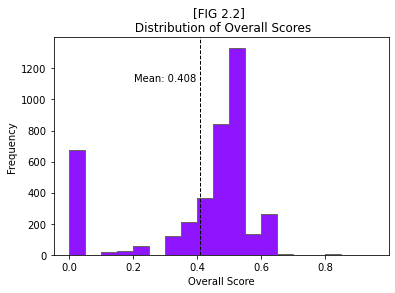

In [16]:
overall_scores = apple_final['overall_score']
plt.hist(overall_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#8f15ff')
plt.hist(overall_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title("[FIG 2.2] \n Distribution of Overall Scores")
plt.axvline(overall_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=overall_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(overall_scores.mean()))
plt.show()

### GENRE SCORE
---

In [17]:
genre_unique = apple_final['genre'].unique()

In [18]:
apple_final['genre_rc'] = np.nan
apple_final['genre_r'] = np.nan
apple_final.head()

app_name              genre  size_bytes  rating_count  \
0                 Facebook  Social Networking   389879808       2974676   
1                Instagram      Photo & Video   113954816       2161558   
2           Clash of Clans              Games   116476928       2130805   
3               Temple Run              Games    65921024       1724546   
4  Pandora - Music & Radio              Music   130242560       1126879   

   rating  overall_rc  overall_r  overall_score  genre_rc  genre_r  
0     3.5    1.000000        0.7       0.820000       NaN      NaN  
1     4.5    0.726653        0.9       0.830661       NaN      NaN  
2     4.5    0.716315        0.9       0.826526       NaN      NaN  
3     4.5    0.579742        0.9       0.771897       NaN      NaN  
4     4.0    0.378824        0.8       0.631530       NaN      NaN

In [19]:
for g in genre_unique:
    # Assigning the score values for 'rc'
    max_rc = apple_final.loc[apple_final['genre'] == g, 'rating_count'].max()
    min_rc = apple_final.loc[apple_final['genre'] == g, 'rating_count'].min()
    apple_final.loc[apple_final['genre'] == g, 'genre_rc'] = (apple_final.loc[apple_final['genre'] == g, 'rating_count'] - min_rc) / (max_rc - min_rc)
    # Assigning the score values for 'r'
    max_r = apple_final.loc[apple_final['genre'] == g, 'rating'].max()
    min_r = apple_final.loc[apple_final['genre'] == g, 'rating'].min()
    apple_final.loc[apple_final['genre'] == g, 'genre_r'] = (apple_final.loc[apple_final['genre'] == g, 'rating'] - min_r) / (max_r - min_r)

In [20]:
apple_final.head()

app_name              genre  size_bytes  rating_count  \
0                 Facebook  Social Networking   389879808       2974676   
1                Instagram      Photo & Video   113954816       2161558   
2           Clash of Clans              Games   116476928       2130805   
3               Temple Run              Games    65921024       1724546   
4  Pandora - Music & Radio              Music   130242560       1126879   

   rating  overall_rc  overall_r  overall_score  genre_rc   genre_r  
0     3.5    1.000000        0.7       0.820000   1.00000  0.700000  
1     4.5    0.726653        0.9       0.830661   1.00000  0.900000  
2     4.5    0.716315        0.9       0.826526   1.00000  0.900000  
3     4.5    0.579742        0.9       0.771897   0.80934  0.900000  
4     4.0    0.378824        0.8       0.631530   1.00000  0.888889

In [21]:
apple_final[['genre_rc', 'genre_r']].isna().value_counts()

genre_rc  genre_r
False     False      4056
dtype: int64

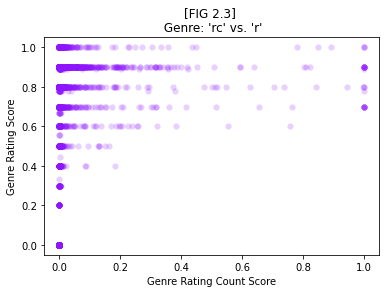

In [22]:
x = apple_final['genre_rc']
y = apple_final['genre_r']
plt.scatter(x, y, c='#8f15ff', alpha=0.2, linewidths=0.1)
plt.xlabel("Genre Rating Count Score")
plt.ylabel("Genre Rating Score")
plt.title("[FIG 2.3] \n Genre: 'rc' vs. 'r'")
plt.show()

In [23]:
apple_final['genre_score'] = (apple_final['genre_rc'] * weight_rc) + (apple_final['genre_r'] * weight_r)

In [24]:
apple_final['genre_score'].describe()

count    4056.000000
mean        0.416617
std         0.207122
min         0.000000
25%         0.360177
50%         0.480812
75%         0.541206
max         1.000000
Name: genre_score, dtype: float64

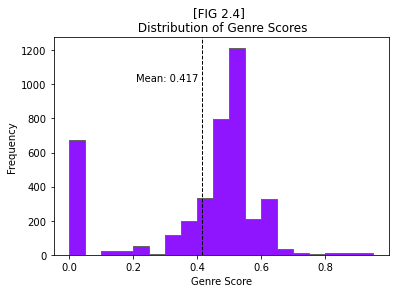

In [25]:
genre_scores = apple_final['genre_score']
plt.hist(genre_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#8f15ff')
plt.hist(genre_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Genre Score')
plt.ylabel('Frequency')
plt.title("[FIG 2.4] \n Distribution of Genre Scores")
plt.axvline(genre_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=genre_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(genre_scores.mean()))
plt.show()

### SUCCESS SCORE
---

We came a long way already, and to recap what we did so far was to clean the data, and then come up with two types of scores. **Overall Score**, which evaluates each app with respect to all other apps; and **Genre Score** which evaluates each app with respect to other apps within the same genre.

To come up with these scores, the properties used were: "rating_count" and "rating" with the weights of <font color=purple>*40% and 60%*</font> respectively.

Now to gather these two scores into one and finally rank them, there is one more weighting system to be considered. After enough trial and error, the least biased way is to consider:
- **Overall Score**: 45%
- **Genre Score**: 55%

The reasoning behind comes back to the objective of this research, that is to produce an analysis capable of understanding the defining elements of an app's success. Success can be a relative concept:
- For most app creators being at the top of your own nieche (in this case, genre) is already a successful achievement.
- However also attracting highlights regardless of the nieche is also very well desired and hardly any developer is going to deny this chance.

> Yet, when it comes to the average app-maker, the first one already satisfy most of their needs, whilst the second is a bit more unrealistic. And for this reason there is a slight increse in the Genre Score weight.

In [26]:
weight_overall = 0.45
weight_genre = 0.55

In [27]:
print('This is a cut of our dataset to show what we have so far:')
apple_final[['app_name', 'genre', 'overall_score', 'genre_score']].head(10)

This is a cut of our dataset to show what we have so far:


app_name              genre  overall_score  genre_score
0                 Facebook  Social Networking       0.820000     0.820000
1                Instagram      Photo & Video       0.830661     0.940000
2           Clash of Clans              Games       0.826526     0.940000
3               Temple Run              Games       0.771897     0.863736
4  Pandora - Music & Radio              Music       0.631530     0.933333
5                Pinterest  Social Networking       0.682755     0.682755
6                    Bible          Reference       0.672575     1.000000
7         Candy Crush Saga              Games       0.669331     0.720550
8            Spotify Music              Music       0.658139     0.911857
9              Angry Birds              Games       0.650863     0.694768

In [28]:
apple_final['success_score'] = (apple_final['overall_score'] * weight_overall) + (apple_final['genre_score'] * weight_genre)

In [29]:
apple_sorted = apple_final.sort_values('success_score', 
                                       ascending=False, 
                                       ignore_index=True)
print("And this is the Top 10 apps by Success Score:")
apple_sorted[['app_name', 'genre','success_score']].head(10)

And this is the Top 10 apps by Success Score:


app_name              genre  \
0                                        Instagram      Photo & Video   
1                                   Clash of Clans              Games   
2                                            Bible          Reference   
3                                       Temple Run              Games   
4    CPlus for Craigslist app - mobile classifieds           Catalogs   
5                                         Facebook  Social Networking   
6  Waze - GPS Navigation, Maps & Real-time Traffic         Navigation   
7                               Domino's Pizza USA       Food & Drink   
8                                    Spotify Music              Music   
9                          Pandora - Music & Radio              Music   

   success_score  
0       0.890798  
1       0.888937  
2       0.852659  
3       0.822408  
4       0.820808  
5       0.820000  
6       0.813879  
7       0.802900  
8       0.797684  
9       0.797522

## 3. <font color=orange>Splitting Sample</font>
To define the borderline between Success & Failure we will:
- Visualize the Success Score distribution
- Defining criteria to create the borderlines
- Separate the datasets into two (success & failure)

In [30]:
apple_sorted['success_score'].describe()

count    4056.000000
mean        0.412678
std         0.202783
min         0.000000
25%         0.360130
50%         0.480555
75%         0.540837
max         0.890798
Name: success_score, dtype: float64

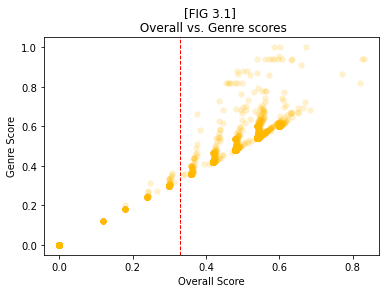

In [31]:
x = apple_sorted['overall_score']
y = apple_sorted['genre_score']
plt.scatter(x, y, c='#ffba00', alpha=0.2, linewidths=0.1)
plt.xlabel("Overall Score")
plt.ylabel("Genre Score")
plt.title("[FIG 3.1] \n Overall vs. Genre scores")
plt.axvline(0.33, 
            color='red', 
            linestyle='dashed', 
            linewidth=1)
plt.show()

*\[FIG 3.1\] It's observable that the <font color=red>red line</font> splits the apps with nearly same score for both Overall and Genre, from the apps in which these scores differs. That is an aspect we will be looking for to define the success borderline, apps which are not necessarily at the top of App Store's ranking, but **still lead their nieche (genre)** are going to be valuable for the outcome of this analysis.*

#### Understanding 'Success Score' blind spot
---

It called my attention that the visualizations from FIG 2.1 to FIG 3.1 weren't presenting that much of a difference. Even though we are double-counting the same criterias 'rc' and 'r' twice, I still believe joining them together adds value because it brings the 'within genre' relevance. However this raises a blind spot:

In [32]:
print('These are how many apps each genre has under it:')
apple_sorted['genre'].value_counts()

These are how many apps each genre has under it:


Games                2257
Entertainment         334
Photo & Video         167
Social Networking     143
Education             132
Shopping              121
Utilities             109
Lifestyle              94
Finance                84
Sports                 79
Health & Fitness       76
Music                  67
Book                   66
Productivity           62
News                   58
Travel                 56
Food & Drink           43
Weather                31
Reference              20
Navigation             20
Business               20
Catalogs                9
Medical                 8
Name: genre, dtype: int64

In [33]:
print('By looking at the genre with least apps:')
apple_sorted[apple_sorted['genre'] == 'Medical']

By looking at the genre with least apps:


app_name    genre  size_bytes  \
10                                  Blink Health  Medical    38117376   
17                SnoreLab : Record Your Snoring  Medical    56814592   
19                              Complete Anatomy  Medical   974118912   
169      Eye Training Cocololo-3dステレオグラム視力回復アプリ-  Medical    66277376   
1876  MyDx One: Find a Strain that Works for You  Medical    38659072   
3642                 Malodo : Stop au mal de dos  Medical    15183872   
3664                  iSleeping by iSommeil SARL  Medical    24419328   
4009                             平安好医生-要健康上平安好医生  Medical   120727552   

      rating_count  rating  overall_rc  overall_r  overall_score  genre_rc  \
10            1198     5.0    0.000403        1.0       0.600161  0.893363   
17            1341     4.5    0.000451        0.9       0.540180  1.000000   
19            1104     4.5    0.000371        0.9       0.540148  0.823266   
169              6     5.0    0.000002        1.0       0.600001  0.004474   
1876            29     4.0    0.000010        0.8       0.480004  0.021626   
3642             0     0.0    0.000000        0.0       0.000000  0.000000   
3664             0     0.0    0.000000        0.0       0.000000  0.000000   
4009             0     0.0    0.000000        0.0       0.000000  0.000000   

      genre_r  genre_score  success_score  
10        1.0     0.957345       0.796612  
17        0.9     0.940000       0.760081  
19        0.9     0.869306       0.721185  
169       1.0     0.601790       0.600985  
1876      0.8     0.488650       0.484759  
3642      0.0     0.000000       0.000000  
3664      0.0     0.000000       0.000000  
4009      0.0     0.000000       0.000000

It called my attention these two apps & it's respective scores:

| Success Rank| app_name | 'rc' | 'r' | overall_rc | overall_r | overall_score |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 19 | Complete Anatomy | 1104 | 4.5 | 0.000371 | 0.9 | 0.540148 |
| 169 | Eye Training Cocololo-3dステレオグラム視力回復アプリ- | 6 | 5.0 | 0.000002 | 1.0 | 0.600001 |

The Eye Training App ended up with a Overall Score higher than the Complete Anatomy app, despite the fact that it has considerably less rating_count. This comes from 2 facts:
1. Minmax Feature Scaling is **very sensitive to the extreme outliers**, so the Complete Anatomy app, even though it has many rating_count and represents the Top 3 in it's nieche, it's overall_rc score still very low.
2. The Eye Training app with a rating average of 5.0 ends up scoring higher in that aspect **due to the low sample size** ('rc'), added the fact that 'r' has a weight slithly higer than 'rc'.

### **What is the blind spot then?**

Although these problems are real, they will only happen under specific circumstances:
- Genre with few apps
- App with few 'rc' but high 'r'

And by exploring the data-set this problem does not repeat very often, at least not in a way that it would affect the final objective of this analysis. Yet, with this in mind, our way forward is to make sure our success borderline doesn't include any apps that might be under this blind-spot.

> And the most effective way to ensure that, is to analyze the Successful Apps sample after creating the cut, and **ensuring that the 'rc' description (min, max, mean) are at an acceptable level** - no one can say an app with less than a hundred 'rc' is really successful, right?

In [34]:
success_cut = 150

In [35]:
print("There are", apple_sorted['genre'].value_counts().shape[0], "genre in the full dataset.")

There are 23 genre in the full dataset.


In [36]:
print("By taking the Top {}, we still at least 1 app representative of all".format(str(success_cut)), apple_sorted['genre'].head(success_cut).value_counts().shape[0], "genres.")

By taking the Top 150, we still at least 1 app representative of all 23 genres.


In [37]:
print("Information about \"rating\":")
print(apple_sorted['rating'].head(success_cut).describe())
print('\n')
print("Information about \"rating_count\":")
print(apple_sorted['rating_count'].head(success_cut).describe())

Information about "rating":
count    150.00000
mean       4.64000
std        0.41821
min        3.50000
25%        4.50000
50%        4.50000
75%        5.00000
max        5.00000
Name: rating, dtype: float64


Information about "rating_count":
count    1.500000e+02
mean     2.515940e+05
std      4.146325e+05
min      8.810000e+02
25%      1.880050e+04
50%      1.110760e+05
75%      3.518050e+05
max      2.974676e+06
Name: rating_count, dtype: float64


In [38]:
apple_success = apple_sorted.copy().head(success_cut)

Based on the information above, it's safe to define that our <font color=green>Success Bordeline</font> will be all Top 150 apps! Now what about the <font color=red>Failure Borderline</font>?

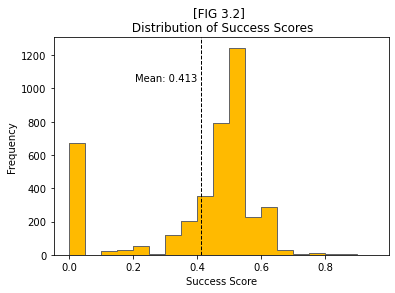

In [39]:
success_scores = apple_sorted['success_score']
plt.hist(success_scores, 
         histtype='barstacked',
         bins=np.arange(0, 1, 0.05), 
         color='#ffba00')
plt.hist(success_scores, 
         histtype='step',
         bins=np.arange(0, 1, 0.05), 
         color='#656565')
plt.xlabel('Success Score')
plt.ylabel('Frequency')
plt.title("[FIG 3.2] \n Distribution of Success Scores")
plt.axvline(success_scores.mean(), 
            color='k', 
            linestyle='dashed', 
            linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x=success_scores.mean()*0.5, 
         y=max_ylim*0.8, 
         s='Mean: {:.3f}'.format(success_scores.mean()))
plt.show()

By looking at \[FIG 3.2\] it's clear how many apps are on the score 0, even after evaluating through the two lenses of Overall Apps and Genre Specific. It's then safe to assume that all that zero-segment should be in the failure borderline. The question is do we include some more?

In [40]:
print("A cut of our dataset including only apps who scored 0:")
apple_zero = apple_sorted.copy()[apple_sorted['success_score'] == 0]
apple_zero.describe()

A cut of our dataset including only apps who scored 0:


size_bytes  rating_count  rating  overall_rc  overall_r  \
count  6.730000e+02         673.0   673.0       673.0      673.0   
mean   9.576497e+07           0.0     0.0         0.0        0.0   
std    1.912636e+08           0.0     0.0         0.0        0.0   
min    1.841152e+06           0.0     0.0         0.0        0.0   
25%    2.826445e+07           0.0     0.0         0.0        0.0   
50%    5.227008e+07           0.0     0.0         0.0        0.0   
75%    1.047276e+08           0.0     0.0         0.0        0.0   
max    3.148421e+09           0.0     0.0         0.0        0.0   

       overall_score  genre_rc  genre_r  genre_score  success_score  
count          673.0     673.0    673.0        673.0          673.0  
mean             0.0       0.0      0.0          0.0            0.0  
std              0.0       0.0      0.0          0.0            0.0  
min              0.0       0.0      0.0          0.0            0.0  
25%              0.0       0.0      0.0          0.0            0.0  
50%              0.0       0.0      0.0          0.0            0.0  
75%              0.0       0.0      0.0          0.0            0.0  
max              0.0       0.0      0.0          0.0            0.0

In [41]:
fail_score = 0.23

In [42]:
print("A cut of our dataset including only apps who scored more than zero and less than {}:".format(fail_score))
apple_fail_nonzero = apple_sorted.copy()[(apple_sorted['success_score'] > 0) & (apple_sorted['success_score'] < fail_score)]
apple_fail_nonzero.describe()

A cut of our dataset including only apps who scored more than zero and less than 0.23:


size_bytes  rating_count     rating    overall_rc  overall_r  \
count  4.700000e+01     47.000000  47.000000  4.700000e+01  47.000000   
mean   8.355527e+07    157.702128   1.276596  5.301489e-05   0.255319   
std    9.318402e+07    366.449292   0.251269  1.231896e-04   0.050254   
min    4.448256e+06      1.000000   1.000000  3.361711e-07   0.200000   
25%    2.604134e+07      1.000000   1.000000  3.361711e-07   0.200000   
50%    6.071910e+07     10.000000   1.500000  3.361711e-06   0.300000   
75%    9.962138e+07     72.500000   1.500000  2.437240e-05   0.300000   
max    5.498470e+08   1999.000000   1.500000  6.720060e-04   0.300000   

       overall_score      genre_rc    genre_r  genre_score  success_score  
count      47.000000  4.700000e+01  47.000000    47.000000      47.000000  
mean        0.153213  3.959480e-04   0.256028     0.153775       0.153522  
std         0.030171  1.078684e-03   0.051126     0.030815       0.030492  
min         0.120000  3.361711e-07   0.200000     0.120000       0.120000  
25%         0.120000  2.915715e-06   0.200000     0.120001       0.120001  
50%         0.180001  1.568856e-05   0.300000     0.180004       0.180003  
75%         0.180007  9.654084e-05   0.300000     0.180045       0.180042  
max         0.180269  5.828515e-03   0.333333     0.200010       0.191006

In [43]:
apple_fail_nonzero[apple_fail_nonzero['rating_count'] > 1000]

app_name      genre  size_bytes  \
3337                           Philips Hue  Lifestyle    73561088   
3338  Celebtwin: Celebrity Looks Like Lite  Lifestyle    81773568   

      rating_count  rating  overall_rc  overall_r  overall_score  genre_rc  \
3337          1999     1.5    0.000672        0.3       0.180269  0.005829   
3338          1111     1.5    0.000373        0.3       0.180149  0.003239   

      genre_r  genre_score  success_score  
3337      0.3     0.182331       0.181403  
3338      0.3     0.181296       0.180780

The apps with score zero by itself already sum a total of 673, however so that we don't consider the score zero as the only criteria, we've done some analysis and it also makes sense to include apps with less than 0.23 success score, and the reason is:
- The rating is extremely low, peaking at 1.5
- Only 2 apps with more than 1000 rating_count*

<div class="alert alert-block alert-info">
<b>(*)</b> This is relevant to bring up because when the fail_score was considered at 0.30 for example, the dataset contained many brands with hundreds of thousands in "rating_count", but they were low located due to the low "rating" - for example McDonalds App. Such brands are known regardless of their apps, and adding them into the Failure Borderline would affect the final analysis.
</div>

With that out of the way, our official <font color=red>Failure Borderline</font> Sample is going to consider apps with success scores ranging form **0 (inclusive) to 0.23 (exclusive)**.

In [44]:
apple_failure = pd.concat([apple_zero, apple_fail_nonzero])
apple_failure.sort_index(inplace=True)
apple_failure.head()

app_name      genre  size_bytes  \
3336   Almanac Long-Range Weather Forecast    Weather    15704064   
3337                           Philips Hue  Lifestyle    73561088   
3338  Celebtwin: Celebrity Looks Like Lite  Lifestyle    81773568   
3339                               TestNav  Education     4448256   
3340      VyStar Mobile Banking for iPhone    Finance    27553792   

      rating_count  rating  overall_rc  overall_r  overall_score  genre_rc  \
3336            12     1.5    0.000004        0.3       0.180002  0.000024   
3337          1999     1.5    0.000672        0.3       0.180269  0.005829   
3338          1111     1.5    0.000373        0.3       0.180149  0.003239   
3339           491     1.5    0.000165        0.3       0.180066  0.003018   
3340           434     1.5    0.000146        0.3       0.180058  0.001861   

       genre_r  genre_score  success_score  
3336  0.333333     0.200010       0.191006  
3337  0.300000     0.182331       0.181403  
3338  0.300000     0.181296       0.180780  
3339  0.300000     0.181207       0.180694  
3340  0.300000     0.180744       0.180436

## 4. <font color=blue>Element's Evalutation</font>
Finding the correlation between the Success Score and the following elements:

- App's genre in comparision to other genres
- App's size in bytes
- App's name length & key words

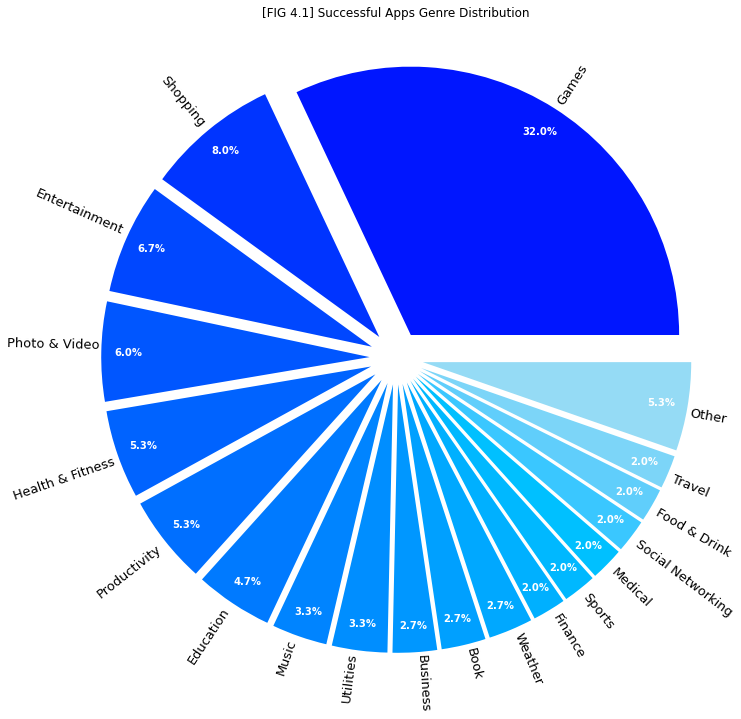

In [73]:
genre_dict = apple_success['genre'].value_counts().to_dict()
threshold = 3
genre_chart = {}

for key, group in itertools.groupby(genre_dict, lambda k: 'Other' if (genre_dict[k] < threshold) else k):
    genre_chart[key] = sum([genre_dict[k] for k in list(group)])   

labels = genre_chart.keys()
sizes = genre_chart.values()
colors = ['#0016ff', '#0034ff', '#0047ff', '#0056ff', '#0063ff', '#006fff', '#007aff', '#0084ff', '#008eff', '#0097ff', '#00a0ff', '#00a8ff', '#00b0ff', '#00b8ff', '#00c0ff', '#3ac7ff', '#60cefb', '#7cd5f8', '#95dbf5']
fig, ax = plt.subplots(figsize=(10,10))
explosion = np.full(len(sizes), 0.1)

patches, texts, autotext = ax.pie(sizes, explode=explosion, labels=labels, colors=colors, autopct='%1.1f%%', pctdistance=0.9, labeldistance=1.005, startangle=0, rotatelabels=True)
ax.axis('equal')
plt.tight_layout()
plt.title('[FIG 4.1] Successful Apps Genre Distribution')
for t in range(len(texts)):
    texts[t].set_fontsize(13)
    texts[t].set_fontfamily('sans-serif')
    
for at in range(len(autotext)):
    autotext[at].set_fontsize(10)
    autotext[at].set_fontfamily('sans-serif')
    autotext[at].set_fontweight('bold')
    autotext[at].set_color('white')
plt.show()

# Reference:
# https://datascience.stackexchange.com/a/71417

In [89]:
x = apple_success[(apple_success['genre'] != 'Catalogs') & (apple_success['genre'] != 'Reference')].groupby('genre')['success_score'].mean().sort_index()

genre
Book                 0.643481
Business             0.649216
Education            0.653440
Entertainment        0.645732
Finance              0.729982
Food & Drink         0.736891
Games                0.631341
Health & Fitness     0.635101
Lifestyle            0.696515
Medical              0.759293
Music                0.683555
Navigation           0.747512
News                 0.633500
Photo & Video        0.638451
Productivity         0.639599
Shopping             0.630349
Social Networking    0.704971
Sports               0.643005
Travel               0.630503
Utilities            0.632385
Weather              0.647192
Name: success_score, dtype: float64

In [78]:
y = apple_success[(apple_success['genre'] != 'Catalogs') & (apple_success['genre'] != 'Reference')].groupby('genre')['success_score'].std().sort_index()

genre
Lifestyle            0.119131
Social Networking    0.105687
Music                0.104159
Photo & Video        0.094833
Food & Drink         0.093905
Navigation           0.093858
Health & Fitness     0.066370
Education            0.061054
Games                0.053459
Shopping             0.051627
Business             0.050413
Entertainment        0.045988
News                 0.039491
Finance              0.038668
Medical              0.037720
Productivity         0.035554
Weather              0.035203
Utilities            0.033073
Travel               0.032682
Book                 0.032208
Sports               0.028262
Catalogs                  NaN
Reference                 NaN
Name: success_score, dtype: float64

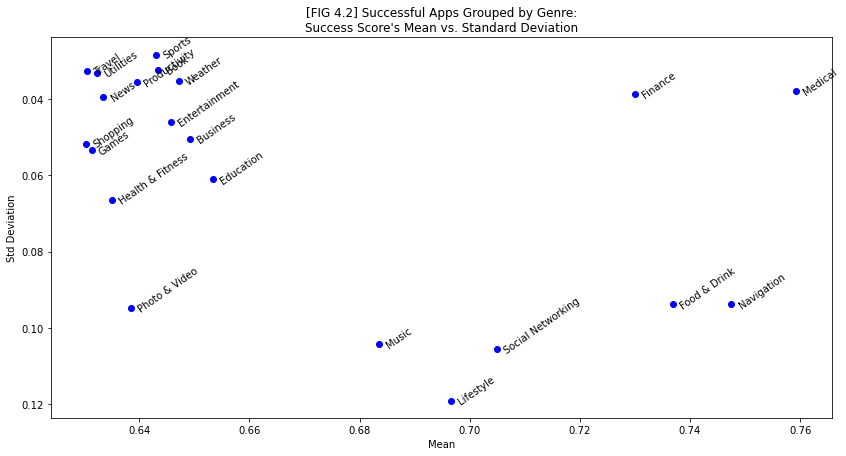

In [135]:
x = apple_success[(apple_success['genre'] != 'Catalogs') & (apple_success['genre'] != 'Reference')].groupby('genre')['success_score'].mean().sort_index()
y = apple_success[(apple_success['genre'] != 'Catalogs') & (apple_success['genre'] != 'Reference')].groupby('genre')['success_score'].std().sort_index()
# Removing the categories 'Catalogs' and 'Reference' as they have only one app

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.scatter(x, y, label=x.index, c='blue')
ax1.set_ylim(ax1.get_ylim()[::-1])
for x_, y_, n in zip(x + 0.001, y + 0.001, range(len(x.to_list()))):
    ax1.text(x_, y_, x.index[n], rotation=35)
ax1.set_xlabel("Mean")
ax1.set_ylabel("Std Deviation")
plt.title('[FIG 4.2] Successful Apps Grouped by Genre:\nSuccess Score\'s Mean vs. Standard Deviation')
plt.show()
